## IMPUTE INSANITY!:
### before we move onto neural networks we need to impute the NANs
#### How do we even know we've correctly imputed?
#### **Try out every impute methods and per feature set train the GBM and see which one got most importance**

### TODO
- #### [KNN , DeepLearner, other novel ways to impute](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
  - KNN thoughts: we can perhaps use subset of features with no nans, but then the records will become similar, and decision trees already predict the same result for similar looking rows? then what's the point of imputing value same as similar looking rows?
- ### DON't Impute rather provide the Flag wether the feature has value or not, kinda like mask; we did this in Optiver (not the transformer sequence mask , but we have mask about weather the second/grouped seconds is missing or not)
  - #### [Results on passing information about missing values to neural networks](https://machinelearningmastery.com/binary-flags-for-missing-values-for-machine-learning/)
- ### AMEND ABOVE: Impute as well as pass the missing Flag too, so neural network learns better
- ### Categorical Imputation: train on data with missing categorical values as target variable! **We can even use TEST set to do this!!!! yay!**
  - #### [Training to find missing categorical values](https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/)

# FLOAT16 aggregations return NONE!!! mean, sum most of it doesn't work :-/

In [1]:
WHERE_THIS = "local" # local|kaggle

BS_DATASET = "amex-default-prediction-binarysentient"
if WHERE_THIS == "kaggle":
    INPUT_PATH = "/kaggle/input/amex-default-prediction/"
    OUTPUT_PATH = "/kaggle/working/"
    TEMP_PATH = "/kaggle/temp/"
elif WHERE_THIS == "local":
    INPUT_PATH = "input/amex-default-prediction/"
    OUTPUT_PATH = "working/"
    TEMP_PATH = "temp/"


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import gc
import os
from datetime import datetime
import torch


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display, HTML
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.model_selection import StratifiedKFold
import plotly.express as pltex

from impute_insanity import load_prepare_amex_dataset
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk(INPUT_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/amex-default-prediction/sample_submission.csv
input/amex-default-prediction/test_data.csv
input/amex-default-prediction/train_data.csv
input/amex-default-prediction/train_labels.csv


In [6]:
df_train = load_prepare_amex_dataset("train_data")

In [15]:
object_features = ['customer_ID']
datetime_features = ['S_2']
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train_dtypes_set = set()
column_dtypes_map = {}
all_columns = []

for columnname in df_train.columns:
        # print(columnname, df_train_peek[columnname].dtype)
    all_columns.append(columnname)
    train_dtypes_set.add(df_train[columnname].dtype.name)
    column_dtypes_map[columnname] = df_train[columnname].dtype.name
numeric_features = list(set(column_dtypes_map.keys()).difference(set(cat_features+datetime_features+object_features)))
print(numeric_features)

['D_94', 'S_24', 'B_11', 'R_24', 'S_3', 'D_130', 'D_115', 'D_78', 'R_3', 'D_56', 'D_80', 'P_4', 'D_112', 'R_22', 'B_1', 'D_144', 'B_2', 'S_22', 'D_81', 'B_16', 'D_141', 'D_92', 'R_6', 'R_20', 'D_62', 'D_106', 'R_16', 'S_12', 'S_25', 'D_122', 'D_79', 'R_13', 'B_27', 'S_15', 'R_23', 'D_72', 'D_53', 'B_24', 'D_75', 'D_60', 'R_11', 'B_19', 'D_42', 'D_108', 'R_15', 'B_31', 'R_18', 'R_28', 'D_71', 'D_87', 'D_41', 'B_18', 'R_26', 'B_10', 'D_82', 'D_142', 'D_65', 'B_37', 'D_69', 'R_9', 'D_138', 'B_23', 'D_58', 'B_32', 'B_39', 'D_113', 'D_131', 'D_109', 'D_76', 'D_39', 'B_12', 'B_29', 'D_48', 'R_8', 'R_27', 'B_13', 'D_119', 'D_86', 'D_145', 'S_11', 'D_45', 'D_52', 'D_44', 'D_47', 'R_1', 'R_19', 'D_49', 'D_136', 'S_20', 'D_89', 'D_55', 'D_118', 'D_135', 'D_61', 'R_7', 'S_18', 'D_54', 'D_84', 'D_140', 'D_104', 'D_143', 'B_4', 'S_26', 'D_46', 'R_21', 'S_23', 'D_105', 'D_88', 'D_110', 'D_134', 'R_25', 'R_10', 'D_70', 'R_17', 'B_41', 'B_25', 'R_12', 'D_59', 'B_36', 'D_51', 'R_14', 'B_33', 'S_8', 'B_

In [16]:
missing_counts_df = df_train.isna().sum().reset_index()
missing_counts_df = missing_counts_df.rename({'index':'columnname', 0:'nan_count'}, axis=1)

In [20]:
missing_features_with_count_list = [x for x in missing_counts_df.to_dict('records') if x['columnname'].startswith('') and x['nan_count']>0]
missing_features_with_count_list = sorted(missing_features_with_count_list, key=lambda x:x['nan_count'])
features_missing_values_count_map = {x['columnname']:x['nan_count'] for x in missing_counts_df.to_dict('records')}
missing_values_features = [x['columnname'] for x in missing_features_with_count_list]

In [22]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def fast_amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

# Need Lightgbm supported eval metric
#Custom eval function expects a callable with following signatures: func(y_true, y_pred), func(y_true, y_pred, weight) or func(y_true, y_pred, weight, group) and returns (eval_name, eval_result, is_higher_better) or list of (eval_name, eval_result, is_higher_better):
def lgbm_eval_metric_amex(y_true, y_pred):
    amex_metric = fast_amex_metric(y_true, y_pred)
    return ('amex', amex_metric, True)

In [26]:
train_label_df = load_prepare_amex_dataset('train_labels')#, index_col='customer_ID')
train_label_df

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.0
...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0.0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0.0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1.0


In [27]:
prediction_labels = train_label_df.copy()
# prediction_labels['prediction'] = prediction_labels['target'] 
# prediction_labels['prediction'] = prediction_labels['target'] - 3
prediction_labels['prediction'] = 1000
del prediction_labels['target'] 


### Predictions impact on Evaluation Metric
- #### all predictions 0 :   score 0.018829875288988086
- #### all predictions 1 :   score 0.018829875288988086
- #### all predictions 0.4 : score 0.018829875288988086
- #### same as target      : score 1.0
- #### target * 10         : score 1.0
- #### target * 0.001      : score 1.0
- #### target - 3          : score 1.0
- #### target + 3          : score 1.0

## The evaluation metrics is solid! amazing, need to understand more
## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays

In [28]:
## TODO: FAST AMEX implementation is not accurate; convert the dataframe accurate version to directly work with numpy arrays
# print(amex_metric(train_labels, prediction_labels))
print(fast_amex_metric(train_label_df['target'], prediction_labels['prediction']))

0.02260958442726859


In [29]:
def create_model_with_config(random_state=1, n_estimators=1200, importance_type=None):
    """
    Creates model with our desired and some default hyper params
    importance_type: split|gain
    """
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, random_state=random_state, importance_type=importance_type)

## Precision impact on scores:

### float32: 0.788541
### float16: 0.788748, 0.788649, 0.788821
### float64: 0.788276, 0.789053, 0.789025, 0.788543

In [36]:
df_train_last1 = variant_df.groupby('customer_ID').last()
df_train_last1 = df_train_last1.reset_index()
df_train_wt = pd.merge(df_train_last1, train_label_df, how='inner', on = 'customer_ID')
df_train_wt

,customer_ID,B_41,B_41_global_mean,B_41_global_min,B_41_global_max,B_41_global_median,B_41_local_mean,B_41_local_linear_interpolate,B_41_local_nearest_interpolate,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.003973,0.003973,0.003973,0.003973,0.003973,NaN,NaN,NaN,0.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.002943,0.002943,0.002943,0.002943,0.002943,NaN,NaN,NaN,0.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.004133,0.004133,0.004133,0.004133,0.004133,NaN,NaN,NaN,0.0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.004254,0.004254,0.004254,0.004254,0.004254,NaN,NaN,NaN,0.0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.001068,0.001068,0.001068,0.001068,0.001068,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0.005314,0.005314,0.005314,0.005314,0.005314,NaN,NaN,NaN,0.0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.005134,0.005134,0.005134,0.005134,0.005134,NaN,NaN,NaN,0.0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0.001513,0.001513,0.001513,0.001513,0.001513,NaN,NaN,NaN,0.0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,0.006067,0.006067,0.006067,0.006067,0.006067,NaN,NaN,NaN,1.0


In [42]:
df_train_wt['B_41_local_linear_interpolate'].describe()

count    690.000000
mean       0.028858
std        0.232675
min        0.000502
25%        0.003447
50%        0.005052
75%        0.006605
max        4.501401
Name: B_41_local_linear_interpolate, dtype: float64

In [45]:
for missingfeaturetuple in missing_features_with_count_list:
    missingvaluefeature = missingfeaturetuple['columnname']
    missingcount = missingfeaturetuple['nan_count']
    print("-------------------------------------")
    print(f"--- {missingvaluefeature}   :  {missingcount} ---")
    variant_df = load_prepare_amex_dataset(f"train_data_{missingvaluefeature}")
    print(variant_df.describe())
    input()

-------------------------------------
--- R_7   :  1 ---
                R_7  R_7_global_mean  R_7_global_min  R_7_global_max  \
count  5.531450e+06     5.531451e+06    5.531451e+06    5.531451e+06   
mean   8.538210e-02     8.538210e-02    8.538208e-02    8.546343e-02   
std    1.548725e+00     1.548725e+00    1.548725e+00    1.560490e+00   
min    8.676290e-10     8.676290e-10    8.676290e-10    8.676290e-10   
25%    2.568756e-03     2.568757e-03    2.568756e-03    2.568757e-03   
50%    5.135867e-03     5.135867e-03    5.135866e-03    5.135867e-03   
75%    7.702539e-03     7.702541e-03    7.702538e-03    7.702541e-03   
max    4.499889e+02     4.499889e+02    4.499889e+02    4.499889e+02   

       R_7_global_median  R_7_local_mean  R_7_local_linear_interpolate  \
count       5.531451e+06        1.000000                       1.00000   
mean        8.538208e-02        0.005415                       0.00257   
std         1.548725e+00             NaN                           NaN  

-------------------------------------
--- R_14   :  1 ---
               R_14  R_14_global_mean  R_14_global_min  R_14_global_max  \
count  5.531450e+06      5.531451e+06     5.531451e+06     5.531451e+06   
mean   2.373128e-01      2.373128e-01     2.373128e-01     2.381873e-01   
std    8.352821e+00      8.352820e+00     8.352820e+00     8.602266e+00   
min    6.702420e-10      6.702420e-10     6.702420e-10     6.702420e-10   
25%    2.535147e-03      2.535148e-03     2.535147e-03     2.535148e-03   
50%    5.069985e-03      5.069985e-03     5.069985e-03     5.069985e-03   
75%    7.608542e-03      7.608544e-03     7.608541e-03     7.608544e-03   
max    4.837305e+03      4.837305e+03     4.837305e+03     4.837305e+03   

       R_14_global_median  R_14_local_mean  R_14_local_linear_interpolate  \
count        5.531451e+06         1.000000                       1.000000   
mean         2.373128e-01         0.003778                       0.002329   
std          8.352820e+00          

-------------------------------------
--- B_40   :  53 ---
               B_40  B_40_global_mean  B_40_global_min  B_40_global_max  \
count  5.531398e+06      5.531451e+06     5.531451e+06     5.531451e+06   
mean   2.011437e-01      2.011436e-01     2.011418e-01     2.550082e-01   
std    8.077985e+00      8.077946e+00     8.077946e+00     1.955910e+01   
min    1.201275e-08      1.201275e-08     1.201275e-08     1.201275e-08   
25%    1.739309e-02      1.739332e-02     1.739220e-02     1.739332e-02   
50%    5.830858e-02      5.831026e-02     5.830736e-02     5.831026e-02   
75%    2.451545e-01      2.451502e-01     2.451502e-01     2.451642e-01   
max    5.755076e+03      5.755076e+03     5.755076e+03     5.755076e+03   

       B_40_global_median  B_40_local_mean  B_40_local_linear_interpolate  \
count        5.531451e+06        53.000000                      53.000000   
mean         2.011423e-01         0.165610                       0.138680   
std          8.077946e+00         

KeyboardInterrupt: Interrupted by user

In [ ]:

%%time
for missingfeaturetuple in missing_features_with_count_list:
    missingvaluefeature = missingfeaturetuple['columnname']
    missingcount = missingfeaturetuple['nan_count']
    print("-------------------------------------")
    print(f"--- {missingvaluefeature}   :  {missingcount} ---")
    variant_df = load_prepare_amex_dataset(f"train_data_{missingvaluefeature}")
    print(variant_df)
    
    df_train_last1 = variant_df.groupby('customer_ID').last()
    df_train_last1 = df_train_last1.reset_index()
    df_train_wt = pd.merge(df_train_last1, train_label_df, how='inner', on = 'customer_ID')#.reset_index()
    
    features_x = [f for f in df_train_wt.columns if f != 'customer_ID' and f != 'target' and f!='S_2']
    feature_y = 'target'
    df_x = df_train_wt[features_x]
    df_y = df_train_wt[feature_y]

    kf = StratifiedKFold(n_splits=5, shuffle=True)
    fold_scores = []
    for fold, (idx_train, idx_dev) in enumerate(kf.split(df_x, df_y)):
        train_x, dev_x, train_y, dev_y, model = None, None, None, None, None
        start_time = datetime.now()
        X_tr = df_train_wt.iloc[idx_train][features_x]
        X_va = df_train_wt.iloc[idx_dev][features_x]
        y_tr = df_train_wt[feature_y][idx_train].values
        y_va = df_train_wt[feature_y][idx_dev].values
        for importance_type in ['split','gain']:
            model = create_model_with_config(importance_type=importance_type)
            model.fit(X_tr, y_tr,
                          eval_set = [(X_va, y_va)], 
                          eval_metric=[lgbm_eval_metric_amex],
                          callbacks=[log_evaluation(100)])

            y_va_pred = model.predict_proba(X_va, raw_score=True)
            score = fast_amex_metric(y_va, y_va_pred)
            n_trees = model.best_iteration_
            if n_trees is None: n_trees = model.n_estimators
            print("-------------------------------------")
            display(HTML(f"<h3>Fold {fold+1} | {str(datetime.now() - start_time)[-12:-7]} |"
                  f" {n_trees:5} trees |"
                  f"                Score = {score:.5f} | Importance: {importance_type}</h3>"))
            print("-------------------------------------")
            fold_scores.append(score)

            feature_importance_tuples = sorted(zip(X_tr.columns,model.feature_importances_), key=lambda x:x[1])
            # feature_importance_tuples = sorted(zip(X_tr.columns,model.feature_importance(importance_type='gain')), key=lambda x:x[1])
            feature_importance_map = {k:v for k,v in feature_importance_tuples}
            feature_imp = pd.DataFrame(feature_importance_tuples, columns=['feature','importance'])
            fig = pltex.bar(feature_imp, x='importance', y='feature', height=500)
            fig.show()


       

    display(HTML(f"<h3>OVERALL SCORE : {np.mean(fold_scores)}</h3>"))

AttributeError: 'LGBMClassifier' object has no attribute 'feature_importance'

In [151]:
feature_importance_map


{'S_3_local_nearest_interpolate': 3922,
 'S_3_global_min': 4375,
 'S_3_local_first': 5075,
 'S_3': 6018,
 'S_3_local_min': 6225,
 'S_3_global_median': 7388,
 'S_3_global_max': 11558,
 'S_3_local_mean': 15447,
 'S_3_global_mean': 15624,
 'S_3_local_max': 15693,
 'S_3_local_linear_interpolate': 16088}

In [ ]:
# feature_imp

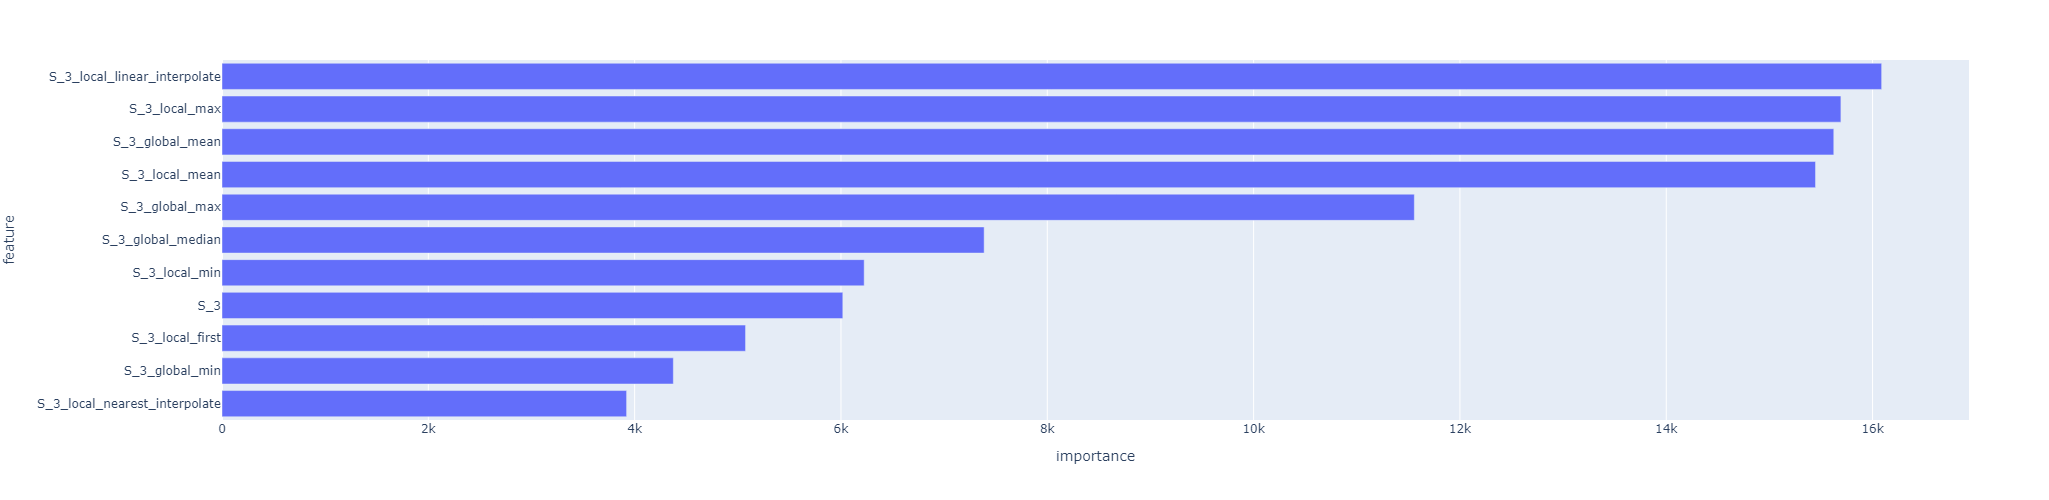

In [ ]:
len(idx_train)